# Нейронные сети в анализе выживаемости

## Модели дискретного времени

В данной лекции мы ограничимся моделями с дискретным временем. Данные модели используют функцию правдоподобия для цензурированных данных для параметризации функции риска с помощью нейронной сети.

Такие модели также могут применяться для данных с непрерывным временем за счет дискретизации времени.

## Функция правдоподобия для цензурированных данных

Пусть у нас есть дискретная временная шкала со значениями $0=\tau_0<\tau_1<...<\tau_i<...$. Обозначим время наступления события как $T$. Мы хотим смоделировать распределение таких временных точек. Для этого опредлим функцию вероятности и функцию выживания:

$$f(\tau_i)=R(T=\tau_i),\\
  S(\tau_i)=P(T>\tau_i)=\sum_{j>i} f(\tau_j)$$

Что из себя представляет функция риска?

$$h(\tau_i)=P(T=\tau_i|T\geq\tau_i)=P(T=\tau_i|T>\tau_{i-1})=\\
=\frac{P(T=\tau_i)}{P(T>\tau_{i-1})}=\frac{f(\tau_i)}{S(\tau_{i-1})}=\\
\frac{\sum_{j>i-1}f(\tau_j)-\sum_{j>i}f(\tau_j)}{S(\tau_{i-1})}=\frac{S(\tau_{i-1})-S(\tau_{i})}{S(\tau_{i-1})}$$

Соответственно:

$$f(\tau_i)=h(\tau_i)S(\tau_{i-1}),\\
S(\tau_i)=[1-h(\tau_i)]S(\tau_{i-1})=\prod_{j=1}^{i}[1-h(\tau_j)]$$

Все это было знакомо нам с прошлых лекций, давайте теперь рассмотрим, как мы будем оперировать цензурированными данными. Пусть $C$ &mdash; время цензурирования. Походим образом как для времени наступления события $T$ мы можем записать свои функцию веротности и "выживания" для цензурированных наблюдений:

$$f_C(\tau_i)=P(C=\tau_i),\\
S_C(\tau_i)=P(C>\tau_i)$$

Поскольку мы не наблюдаем одновременно наступление события и цензурирование мы можем обозначить общую продолжительность наблюдения за индивидом:

$$T^*=\min \{T,C\}$$

Зададим также индикатор того, что событие произошло:

$$D=I\{T \leq C\}$$

Здесь мы подразумеваем, что если времы наступления события совпадает с цензурированием, то мы считаем, что событие произошло.Также стоит отметить, что время до цензурирования будет ограничено точкой $\tau_m$ ($C\in \mathcal{T}_C=\{\tau_1, ..., \tau_m \})$ и соответственно мы не можем наблюдать время наступления события больше, чем $\tau_m$.

Считая, что $Т$ и $С$ независимы, можем вывести функцию правдоподобия выживания для цензурированных данных для $t \in \mathcal{T}_C$ и $d\in\{0,1\}$.

$$P(T^*=t, D=d) = P(T=t, C\geq t)^dP(T>t, C=t)^{1-d}=\\
=[P(T=t)P(C\geq t)]^d[P(T>t)P(C=t)]^{1-d}=\\
=[f(t)(S_C(t)+f_C(t))]^d[S(T)f_C(t)]^{1-d}=\\
[f(t)^dT(t)^{1-d}][f_C(t)^{1-d}(S_C(t)+f_C(t))^d]$$


Мы можем предположить, что функции вероятности $f(t)$ и $f_C(t)$ будут параметризоваться по-разному, соответственно можем рассматривать их вклад в правдоподобие отдельно. Нам интересно моделировать распределение времени до наступления события, в этом случае, для каждого объекта $i$, мы получаем его вклад в правдоподобие:

$$L_i=f(t_i)^{d_i}S(t_i)^{1-d_i}$$

Итак, мы имеем $n$ объектов, у каждого из которых есть признаки $x_i$, наблюдаемое время $t_i$ и индикатор события $d_i$, таким образом мы можем параметризировать модели, уменьшая отрицательное правдоподобие:

$$loss=-\frac{1}{n}\sum_{i=1}^n(d_i\log[f(t_i|x_i)]+(1-d_i)\log[S(t_i|x_i)])$$




Также мы можем параметризировать функцию риска, для этого нам нужно переписать вклад в правдоподобие для индивидуального объекта:

$$ L_i=f(t_i)^{d_i} S(t_i)^{1-d_i}=$$

$$=[h(t_i)S(\tau_{k(t_i)-1})]^{d_i}[(1-h
(t_i))S(\tau_{k(t_i)-1})]^{1-d_i}=$$

$$=h(t_i)^{d_i}[1-h(t_i)]^{1-d_i}S(\tau_{k(t_i)-1})=$$

$$=h(t_i)^{d_i}[1-h(t_i)]^{1-d_i}\prod_{j=1}^{k(t_i)-1}[1-h(\tau_j)]$$

В такой формулировке наш лосс приобретает другой вид:

$$loss = -\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^{k(t_i)}(y_{ij}\log[h(\tau_j|x_i)]+(1-y_{ij})\log[1-h(\tau_j|x_i)])$$

Здесь $y_{ij}=I\{t_i=\tau_j, d_i=1\}$, таким образом, $y_i$ представляет вектор из нулей и одной 1 для того индекса, когда $t_i$ соответствует наступлению события $(d_i=1)$

## Параметризация с помощью нейронной сети

Итак, мы увидвели, чт оправдоподобие выживаемости может быть выражено через функцию вероятности или через функцию риска.

Рассмотрим параметризацию функции риска:

Пусть $\phi(x)$ &mdash; нейронная сеть, которая принимает на вход параметры $x$, а на выход возвращает $m$ значений, соответствующих каждой временной точке $\tau_j$, т.е. $\phi(x)=\{\phi_1(x), ..., \phi_m(x)\}$. Поскольку риск &mdash; это вероятность, дополнительно к выходам нейронной сети мы применяем функцию сигмоиды:

$$h(\tau_j|x)=\frac{1}{1+\exp [-\phi_j(x)]}$$

Таким образом, минимизируя лосс, мы можем получать оценку функции выживания

$$S(\tau_i)=\prod_{j=1}^{i}[1-h(\tau_j)]$$

Данный метод называетя __Logistic Hazard__

Давайте попробуем применить то, что мы вывели на практике

In [ ]:
! pip install lifelines
! pip install torchtuples
! pip install pycox

from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
import pandas as pd
import lifelines
import numpy as np
import matplotlib.pyplot as plt

# For building the networks
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchtuples as tt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

# MNIST is part of torchvision
from torchvision import datasets, transforms

In [ ]:
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
from pycox.evaluation import EvalSurv

In [ ]:
np.random.seed(42)
torch.manual_seed(42);

Загрузим датасет и разобьем его на тренировочный, валидационный и тестовый наборы:

In [ ]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [ ]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
7,5.916774,5.289600,12.981733,6.009507,0.0,1.0,0.0,1.0,64.610001,143.000000,1
9,7.125732,5.484323,10.498713,6.128778,0.0,0.0,0.0,0.0,80.339996,49.433334,1


Для того, чтобы работать с нейронными сетями, необходима предварительная обработка данных, в частности, признаки, имеющие непрерывное распределение нужно нормализовать

In [ ]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [ ]:
def get_target(df):

    return (df['duration'].values, df['event'].values)

In [ ]:
num_durations = 10
scheme =  'quantiles'  # 'equidistant

labtrans = LogisticHazard.label_transform(num_durations, scheme)

y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

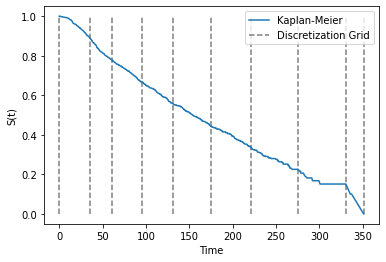

In [ ]:
from pycox.utils import kaplan_meier

plt.vlines(labtrans.cuts, 0, 1, colors='gray', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
plt.xlabel('Time');

In [ ]:
labtrans.cuts

array([  0.     ,  35.4    ,  60.9    ,  95.86667, 131.33333, 174.56667,
       221.23334, 275.23334, 330.36667, 351.     ], dtype=float32)

Попробуем использовать двухслойную нейронную сеть для моделирования функции риска:

In [ ]:
class Surv_MLP(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super(Surv_MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_size[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[0]),
            nn.Dropout(0.1),

            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[1]),
            nn.Dropout(0.1),

            torch.nn.Linear(hidden_size[1], out_features)
            )

    def forward(self, x):
        x = self.net(x)
        return  x

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_size = 256
epochs = 20

net = Surv_MLP(in_features, num_nodes, out_features)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)
log = model.fit(x_train, y_train, batch_size, epochs, val_data=val)

0:	[0s / 0s],		train_loss: 3.0000,	val_loss: 2.7959
1:	[0s / 0s],		train_loss: 2.7169,	val_loss: 2.5771
2:	[0s / 0s],		train_loss: 2.4591,	val_loss: 2.2604
3:	[0s / 0s],		train_loss: 2.1640,	val_loss: 1.9164
4:	[0s / 0s],		train_loss: 1.8183,	val_loss: 1.6346
5:	[0s / 0s],		train_loss: 1.5656,	val_loss: 1.4789
6:	[0s / 0s],		train_loss: 1.4232,	val_loss: 1.4340
7:	[0s / 1s],		train_loss: 1.4037,	val_loss: 1.4334
8:	[0s / 1s],		train_loss: 1.3686,	val_loss: 1.4162
9:	[0s / 1s],		train_loss: 1.3478,	val_loss: 1.4044
10:	[0s / 1s],		train_loss: 1.3202,	val_loss: 1.3968
11:	[0s / 1s],		train_loss: 1.2968,	val_loss: 1.4020
12:	[0s / 1s],		train_loss: 1.2888,	val_loss: 1.3953
13:	[0s / 1s],		train_loss: 1.2861,	val_loss: 1.3931
14:	[0s / 1s],		train_loss: 1.2699,	val_loss: 1.3981
15:	[0s / 1s],		train_loss: 1.2648,	val_loss: 1.4130
16:	[0s / 1s],		train_loss: 1.2498,	val_loss: 1.4142
17:	[0s / 1s],		train_loss: 1.2561,	val_loss: 1.4217
18:	[0s / 1s],		train_loss: 1.2586,	val_loss: 1.4225
19:

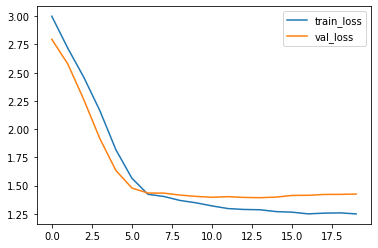

In [ ]:
log.plot();

In [ ]:
log.to_pandas().val_loss.min()

1.3930621147155762

## Prediction

In [ ]:
surv = model.predict_surv_df(x_test)

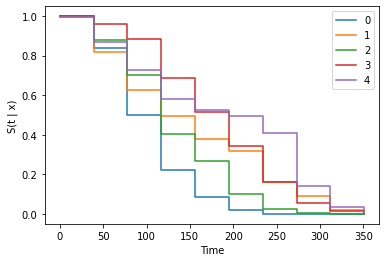

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td()

0.5929899271148964

## MNIST

Преимущество использования нейронных сетей состоит в том, что они позволяют работать с такими форматами данных, с которыми не могут работать другие модели, например с изображениями

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
     )
mnist_train = datasets.MNIST('../data', train=True, download=True,
                             transform=transform)
mnist_test = datasets.MNIST('../data', train=False, transform=transform)

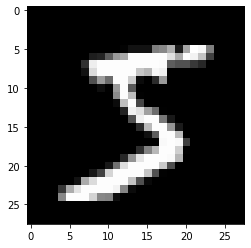

In [ ]:
plt.imshow(mnist_train[0][0][0].numpy(), cmap='gray');

Симулируем для каждого числа время жизни в соответствии с экспоненциальным распределением:

$$\beta = \frac{365\cdot\exp(-0.4\cdot digit)}{\ln(2)}$$

$$PDF(t, \frac{1}{\beta})=\frac{1}{\beta}\exp(-\frac{t}{\beta})$$

In [ ]:
def sim_event_times(mnist, max_time=365):
    digits = mnist.targets.numpy()
    betas = 365 * np.exp(-0.4 * digits) / np.log(2)
    event_times = np.random.exponential(betas)
    censored = event_times > max_time
    event_times[censored] = max_time
    return event_times, ~censored

In [ ]:
train_durations, train_events = sim_event_times(mnist_train)
test_durations, test_events = sim_event_times(mnist_test)

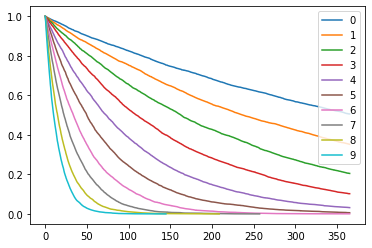

In [ ]:
for i in range(10):
    idx = mnist_train.targets.numpy() == i
    kaplan_meier(train_durations[idx], train_events[idx]).rename(i).plot()
plt.legend();

In [ ]:
labtrans = LogisticHazard.label_transform(20, 'equidistant')
target_train = labtrans.fit_transform(train_durations, train_events)
target_test = labtrans.transform(test_durations, test_events)

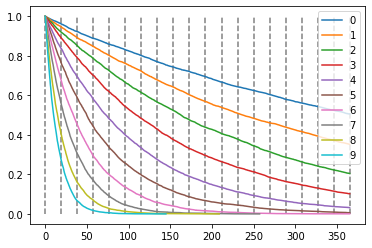

In [ ]:
for i in range(10):
    idx = mnist_train.targets.numpy() == i
    kaplan_meier(train_durations[idx], train_events[idx]).rename(i).plot()
plt.legend();

plt.vlines(labtrans.cuts, 0, 1, colors='gray', linestyles="--", label='Discretization Grid');

Для работы с MNIST нам понадобится создать `Dataset` и `Dataloader`:

In [ ]:
class MnistSimDataset(Dataset):
    """Simulatied data from MNIST. Read a single entry at a time.
    """
    def __init__(self, mnist_dataset, time, event):
        self.mnist_dataset = mnist_dataset
        self.time = torch.from_numpy(time)
        self.event = torch.from_numpy(event).type(torch.float)

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):

        img = self.mnist_dataset[index][0]
        return img, (self.time[index], self.event[index])

def collate_fn(batch):
    """Stacks the entries of a nested tuple"""
    return tt.tuplefy(batch).stack()

In [ ]:
target_train

(array([2, 2, 4, ..., 2, 3, 1]),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [ ]:
dataset_train = MnistSimDataset(mnist_train, *target_train)
dataset_test = MnistSimDataset(mnist_test, *target_test)

In [ ]:
batch_size = 512
dl_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
class Surv_CNN(nn.Module):
    def __init__(self, out_features):
        super(Surv_CNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=8,
                      kernel_size=5,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(8, 16, 5, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.linear_stack = nn.Sequential(
            nn.Linear(16, out_features),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.linear_stack(x)
        return x


In [ ]:
net = Surv_CNN(labtrans.out_features)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)

In [ ]:
log = model.fit_dataloader(dl_train, epochs=20, val_dataloader=dl_test)

0:	[44s / 44s],		train_loss: 4.1631,	val_loss: 3.1009
1:	[23s / 1m:8s],		train_loss: 2.7332,	val_loss: 2.4743
2:	[23s / 1m:31s],		train_loss: 2.3881,	val_loss: 2.3486
3:	[23s / 1m:55s],		train_loss: 2.3109,	val_loss: 2.2917
4:	[26s / 2m:22s],		train_loss: 2.2749,	val_loss: 2.2661
5:	[25s / 2m:48s],		train_loss: 2.2487,	val_loss: 2.2405
6:	[23s / 3m:12s],		train_loss: 2.2310,	val_loss: 2.2346
7:	[23s / 3m:35s],		train_loss: 2.2186,	val_loss: 2.2980
8:	[23s / 3m:58s],		train_loss: 2.2077,	val_loss: 2.2219
9:	[23s / 4m:22s],		train_loss: 2.2004,	val_loss: 2.2554
10:	[23s / 4m:45s],		train_loss: 2.1957,	val_loss: 2.1953
11:	[23s / 5m:9s],		train_loss: 2.1886,	val_loss: 2.2255
12:	[23s / 5m:33s],		train_loss: 2.1855,	val_loss: 2.1854
13:	[25s / 5m:58s],		train_loss: 2.1811,	val_loss: 2.1813
14:	[23s / 6m:21s],		train_loss: 2.1781,	val_loss: 2.1768
15:	[23s / 6m:45s],		train_loss: 2.1756,	val_loss: 2.1817
16:	[23s / 7m:8s],		train_loss: 2.1705,	val_loss: 2.1754
17:	[22s / 7m:31s],		train_los

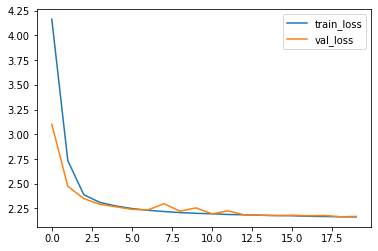

In [ ]:
log.plot();

In [ ]:
class MnistSimInput(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        img = self.mnist_dataset[index][0]
        return img

In [ ]:
dataset_test_x = MnistSimInput(mnist_test)
dl_test_x = DataLoader(dataset_test_x, batch_size, shuffle=False)

In [ ]:
surv = model.predict_surv_df(dl_test_x)

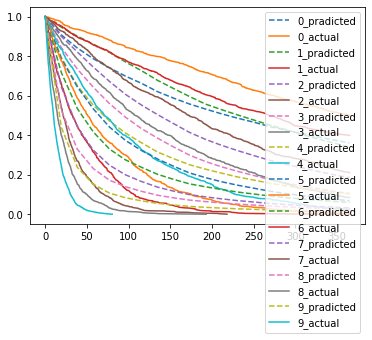

In [ ]:
for i in range(10):
    idx = mnist_test.targets.numpy() == i
    surv.loc[:, idx].mean(axis=1).rename(f'{i}_pradicted').plot(style='--')
    kaplan_meier(test_durations[idx], test_events[idx]).rename(f'{i}_actual').plot()
plt.legend();

In [ ]:
ev = EvalSurv(surv, test_durations, test_events, 'km')
ev.concordance_td()

0.6706011206369256

# Задание

Используя технику transfer learning и нейронную сеть mobilnet_v2, добейтесь улучшения качества моделирования функции выживания по сравнению с примером из лекции

In [ ]:
from torchvision.models import mobilenet_v2

model = mobilenet_v2()
print(model)